# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 05.02.2021

Мягкий дедлайн: 01:59MSK 21.02.2021

Жесткий дедлайн: 01:59MSK 24.02.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [ ]:
pip install keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [ ]:
import keras
from keras.datasets import fashion_mnist


(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import math as m
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA:
          self.use_PCA = PCA(n_components=self.new_dim)
          df = self.use_PCA.fit(X)
          df = df.transform(X)
        else:
          df = X.copy()
          self.new_dim = df.shape[1]

        pairs = (np.square(df.shape[0]) - 1) / 2
        fst = np.random.randint(0, df.shape[0], min(1000000, pairs))
        scd = np.random.randint(0, df.shape[0], min(1000000, pairs))
        ind = fst != scd
        fst = fst[ind]
        scd = scd[ind]
        sigma2 = np.median(np.sum(np.square(df[fst] - df[scd]), axis=1))
        self.w = np.random.normal(0, 1 / np.sqrt(sigma2), self.new_dim * self.n_features)\
            .reshape(self.n_features, self.new_dim)
        self.b = np.random.uniform(-m.pi, m.pi, self.n_features)
        phi = np.cos(np.dot(df, self.w.T) + self.b)
        if self.classifier == 'logreg':
            self.classifier = LogisticRegression(max_iter=10000)
        else:
            self.classifier = LinearSVC(max_iter=10000)
        self.classifier.fit(phi, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA is not False:
            df = self.use_PCA.transform(X)
        else:
            df = X.copy()
        phi = np.cos(np.dot(df, self.w.T) + self.b)
        return self.classifier.predict_proba(phi)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA is not False:
            df = self.use_PCA.transform(X)
        else:
            df = X.copy()
        phi = np.cos(np.dot(df, self.w.T) + self.b)
        return self.classifier.predict(phi)

In [ ]:
from sklearn.metrics import accuracy_score


task = RFFPipeline(classifier='logreg')
task.fit(x_train, y_train)
y_pred = task.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8795


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [ ]:
import time as t

task1 = RFFPipeline(classifier='svm')
t1 = t.time()
task1.fit(x_train, y_train)
t2 = t.time()
y_pred1 = task1.predict(x_test)
t3 = t.time()
print('RFF SVM accuracy:', accuracy_score(y_test, y_pred1), '\n', 
     'fit time:', t2 - t1, '\n',
     'predict time:', t3 - t2)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RFF SVM accuracy: 0.8778 
 fit time: 2402.9886565208435 
 predict time: 0.5070657730102539


In [ ]:
task2 = LinearSVC(max_iter=10000)
t1 = t.time()
task2.fit(x_train, y_train)
t2 = t.time()
y_pred2 = task2.predict(x_test)
t3 = t.time()
print('Linear SVM accuracy:', accuracy_score(y_test, y_pred2), '\n', 
     'fit time:', t2 - t1, '\n',
     'predict time:', t3 - t2)

Linear SVM accuracy: 0.7434 
 fit time: 2998.98811006546 
 predict time: 0.03526806831359863


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
!pip install catboost


     |████████████████████████████████| 65.8MB 71kB/s 


In [ ]:
from catboost import CatBoostClassifier
from tqdm import tqdm

pca = PCA(n_components=50)
pca.fit(x_train)
X_train = pca.transform(x_train)
X_test = pca.transform(x_test)
learning_rate = [0.1, 0.05, 0.01]
n_estimators = [500, 1000, 2000]
models = []
accuracies = []
for eta in learning_rate:
  for trees in tqdm(n_estimators):
    model = CatBoostClassifier(
      random_seed=42,
      logging_level='Silent',
      learning_rate=eta,
      n_estimators=trees
    )
    t1 = t.time()
    model.fit(X_train, y_train)
    t2 = t.time()
    y_pred = model.predict(X_test)
    t3 = t.time()
    models.append((eta, trees, t2 - t1, t3 - t2))
    accuracies.append(accuracy_score(y_test, y_pred))

ind = np.argmax(accuracies)
print('Catbost with eta:', models[ind][0], 'and n_estimators:', models[ind][1], '\n',
      'accuracy:', accuracies[ind], '\n', 
      'fit time:', models[ind][2], '\n',
      'predict time:', models[ind][3])



100%|██████████| 3/3 [26:49<00:00, 536.65s/it]

100%|██████████| 3/3 [26:55<00:00, 538.37s/it]

100%|██████████| 3/3 [26:18<00:00, 526.21s/it]

Catbost with eta: 0.1 and n_estimators: 2000 
 accuracy: 0.8802 
 fit time: 904.7086944580078 
 predict time: 0.20457911491394043


Подведём итоги:

Самый плохой вариант во всех смыслах -- обычный линейный SVM. Он проигрывает и по времени обучения и по качеству. Вообще я не смогла подобрать такое число итераций, чтобы метод сходился и работал за конечное время. При 100 000 итераций я за сутки не дождалась окончания работы и решила оставить так. Это происходит потому, что выборка линейно неразделима.

Ядровой SVM даёт значительно лучшее качество, но время предсказания дольше. 

Самое лучшее качество дает Бустинг с PCA. По времени он обучается тоже быстро, но в подсчетах не учитывался подбор длины шага и числа деревьев, возможно при выборе гиперпараметров для других методов, в частности для Ядрового SVM, там качество оказалось бы еще лучше.

Очевидно, что преобразование признаков имеет смысл, и его стоит использовать, когда нет необходимости сделать предсказание быстро.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [ ]:
task = RFFPipeline(classifier='svm', use_PCA=False)
indexes = np.random.choice(x_train.shape[0], int(x_train.shape[0] * 0.5), replace = False)
X_train = x_train[indexes]
Y_train = y_train[indexes]
t1 = t.time()
task.fit(X_train, Y_train)
t2 = t.time()
y_pred1 = task.predict(x_test)
t3 = t.time()
print('RFF SVM without PCA accuracy:', accuracy_score(y_test, y_pred1), '\n', 
     'fit time:', t2 - t1, '\n',
     'predict time:', t3 - t2)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RFF SVM without PCA accuracy: 0.1004 
 fit time: 1007.1245582103729 
 predict time: 0.9164285659790039


При неиспользовании PCA качество становится заметно хуже. Скорее всего, алгоритм переобучается, тк подгоняется под слишком большое число признаков. А также признаки становятся слишком рандомными и нелогичными. 

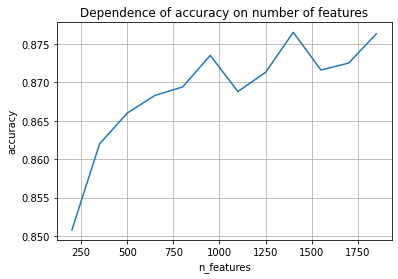

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

features = np.arange(200, 2000, 150, dtype=int)
indexes = np.random.choice(x_train.shape[0], int(x_train.shape[0] * 0.5), replace = False)
X_train = x_train[indexes]
Y_train = y_train[indexes]
accuracies = []
for feature in features:
  model = RFFPipeline(n_features=feature, classifier='svm')
  model.fit(X_train, Y_train)
  accuracies.append(accuracy_score(y_test, model.predict(x_test)))

fig, ax = plt.subplots()
ax.plot(features, accuracies)

ax.set(xlabel='n_features', ylabel='accuracy',
       title='Dependence of accuracy on number of features')
ax.grid()

plt.show()

Заметим, что при увеличении n_features, качество также постепенно увеличивается. В данном случае максимальным значением гиперпараметра я выставила 2000 и выхода на плато не зафиксировала. Алгоритм при этом значении уже работал достаточно долго, поэтому увеличивать еще больше я не стала. Из той тенденции, что мы можем наблюдать сейчас, видно, что где-то с значения 800 n_features кривая начинает колебаться. Скорее всего, так бы продолжалось и далее, только с меньшим диапазоном. 

In [ ]:
model = RFFPipeline(classifier='svm')
model.fit(x_train, y_train)
print('SVM accuracy:', accuracy_score(y_test, model.predict(x_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM accuracy: 0.8802


В самом первом запуске алгоритма, для логистической регрессии, качество равнялось 0,8795. Для SVM оно стало незначительно лучше: 0,8802. Таким образом, Ядровой SVM работает немного лучше, но разница небольшая, поэтому, можно сказать, неважно, какой классификатор использовать. 


### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


class RFFPipeline_new(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier=LogisticRegression(), phi='cos'):
        """
        classiffier is one of the svm, logreg, tree, forest
        phi is one of the cos, sign, mod
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.phi = phi
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        if self.use_PCA:
            self.use_PCA = PCA(n_components=self.new_dim)
            df = self.use_PCA.fit(X)
            df = df.transform(X)
        else:
            df = X.copy()
            self.new_dim = df.shape[1]

        pairs = (np.square(df.shape[0]) - 1) / 2
        fst = np.random.randint(0, df.shape[0], min(1000000, pairs))
        scd = np.random.randint(0, df.shape[0], min(1000000, pairs))
        ind = fst != scd
        fst = fst[ind]
        scd = scd[ind]
        sigma2 = np.median(np.sum(np.square(df[fst] - df[scd]), axis=1))
        self.w = np.random.normal(0, 1 / np.sqrt(sigma2), self.new_dim * self.n_features)\
            .reshape(self.n_features, self.new_dim)
        self.b = np.random.uniform(-m.pi, m.pi, self.n_features)
        if self.phi == 'cos':
          phi = np.cos(np.dot(df, self.w.T) + self.b)
        elif self.phi == 'sign':
          phi = np.sign(np.dot(df, self.w.T) + self.b)
        elif self.phi == 'mod':
          phi = (np.dot(df, self.w.T) + self.b) % 10
        elif self.phi == 'e':
          phi = np.exp(-(np.dot(df, self.w.T) + self.b))
        self.classifier.fit(phi, y)
        return self

    def predict_proba(self, X):
        if self.use_PCA is not False:
            df = self.use_PCA.transform(X)
        else:
            df = X.copy()
        if self.phi == 'cos':
          phi = np.cos(np.dot(df, self.w.T) + self.b)
        elif self.phi == 'sign':
          phi = np.sign(np.dot(df, self.w.T) + self.b)
        elif self.phi == 'mod':
          phi = (np.dot(df, self.w.T) + self.b) % 10
        elif self.phi == 'e':
          phi = np.exp(-(np.dot(df, self.w.T) + self.b))
        return self.classifier.predict_proba(phi)
        
    def predict(self, X):
        if self.use_PCA is not False:
            df = self.use_PCA.transform(X)
        else:
            df = X.copy()
        if self.phi == 'cos':
          phi = np.cos(np.dot(df, self.w.T) + self.b)
        elif self.phi == 'sign':
          phi = np.sign(np.dot(df, self.w.T) + self.b)
        elif self.phi == 'mod':
          phi = (np.dot(df, self.w.T) + self.b) % 10
        elif self.phi == 'e':
          phi = np.exp(-(np.dot(df, self.w.T) + self.b))
        return self.classifier.predict(phi)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

classes = [LinearSVC(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]
phi = ['cos', 'sign', 'mod', 'e']
indexes = np.random.choice(x_train.shape[0], int(x_train.shape[0] * 0.3), replace = False)
X_train = x_train[indexes]
Y_train = y_train[indexes]

for f in phi:
  for i in tqdm(range(4)):
    print('\n')
    if i == 2:
      acc = 0
      d = None
      l = None
      cl = None
      for i, max_depth in enumerate([2, 8, None]):
        for j, min_samples_leaf in enumerate([12, 5, 2]):
          clas = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
          model = RFFPipeline_new(classifier=clas, phi=f, use_PCA=True)
          model.fit(X_train, Y_train)
          y_pred = model.predict(x_test)
          if accuracy_score(y_test, y_pred) > acc:
            acc = accuracy_score(y_test, y_pred)
            d = max_depth
            l = min_samples_leaf
            cl = clas
      print('\nclassification:', cl, '\n',
            'max_depth:', d, '\n',
            'min_samples_leaf:', l, '\n',
            'phi:', f, '\n',
            'accuracy:', acc)
    elif i == 3:
      acc = 0
      e = None
      cl = None
      estimators = 10**np.arange(1, 3)
      for estimator in estimators:
        clas = RandomForestClassifier(n_jobs=-1, n_estimators=estimator)
        model = RFFPipeline_new(classifier=clas, phi=f, use_PCA=True)
        model.fit(X_train, Y_train)
        y_pred = model.predict(x_test)
        if accuracy_score(y_test, y_pred) > acc:
          acc = accuracy_score(y_test, y_pred)
          e = estimator
          cl = clas
      print('\nclassification:', cl, '\n',
            'n_estimators:', e, '\n',
            'phi:', f, '\n',
            'accuracy:', acc)
    else:
      model = RFFPipeline_new(classifier=classes[i], phi=f, use_PCA=True)
      model.fit(X_train, Y_train)
      y_pred = model.predict(x_test)
      print('\nclassification:', classes[i], '\n',
            'phi:', f, '\n',
            'accuracy:', accuracy_score(y_test, y_pred))

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:46<05:19, 106.57s/it]


classification: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0) 
 phi: cos 
 accuracy: 0.8589




 50%|█████     | 2/4 [02:11<02:44, 82.13s/it] 


classification: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 
 phi: cos 
 accuracy: 0.8512




 75%|███████▌  | 3/4 [06:13<02:09, 129.92s/it]


classification: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 
 max_depth: None 
 min_samples_leaf: 12 
 phi: cos 
 accuracy: 0.7652




  0%|          | 0/4 [00:00<?, ?it/s]


classification: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False) 
 n_estimators: 100 
 phi: cos 
 accuracy: 0.8434




 25%|██▌       | 1/4 [02:13<06:39, 133.09s/it]


classification: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0) 
 phi: sign 
 accuracy: 0.8063




 50%|█████     | 2/4 [02:38<03:21, 100.86s/it]


classification: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 
 phi: sign 
 accuracy: 0.8144




 75%|███████▌  | 3/4 [03:20<01:23, 83.00s/it] 


classification: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 
 max_depth: None 
 min_samples_leaf: 12 
 phi: sign 
 accuracy: 0.7528




  0%|          | 0/4 [00:00<?, ?it/s]


classification: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False) 
 n_estimators: 100 
 phi: sign 
 accuracy: 0.8286




 25%|██▌       | 1/4 [02:24<07:14, 144.96s/it]


classification: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0) 
 phi: mod 
 accuracy: 0.8011




 50%|█████     | 2/4 [02:50<03:38, 109.03s/it]


classification: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 
 phi: mod 
 accuracy: 0.8203




 75%|███████▌  | 3/4 [06:41<02:25, 145.69s/it]


classification: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 
 max_depth: None 
 min_samples_leaf: 12 
 phi: mod 
 accuracy: 0.7639




  0%|          | 0/4 [00:00<?, ?it/s]


classification: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False) 
 n_estimators: 100 
 phi: mod 
 accuracy: 0.8407




 25%|██▌       | 1/4 [02:46<08:19, 166.48s/it]


classification: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0) 
 phi: e 
 accuracy: 0.827




 50%|█████     | 2/4 [03:11<04:08, 124.07s/it]


classification: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 
 phi: e 
 accuracy: 0.8408




 75%|███████▌  | 3/4 [07:07<02:37, 157.53s/it]


classification: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 
 max_depth: None 
 min_samples_leaf: 12 
 phi: e 
 accuracy: 0.7749




100%|██████████| 4/4 [08:14<00:00, 123.61s/it]


classification: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False) 
 n_estimators: 100 
 phi: e 
 accuracy: 0.8472


В данном случае я по максимуму ускоряла работу алгоритма (уменьшение числа итераций, уменьшение обучающей выборки), тк без этого ячейка работала бы сто лет, поэтому результаты не превзошли то, что уже было. (Результаты SVM и LogReg не совпадают с тем, что было, так что это точно ускоряющие изменения так повлияли, без них, качество наверняка было бы заметно лучше).

Здесь я добавила такие функции, как e^-(скалярное произведение), mod 10 от скалярного произведения. Новые классификаторы: Дерево решений и Случайный лес с подбором гиперпараметров.

Среди текущих лучшим по-прежнему является Ядровой SVM с качеством 0.8589 с phi с косинусом. Не далеко ушла Логистическая регрессия на той же функции с качеством 0.8512. Чуть хуже Случайный лес: 0.8434. Этот классификатор показал неплохие результаты на всех функциях (причём лучший свой результат с экспонентой), поэтому, наверное, его можно выделить как самый подходящий.

Решающие деревья везде показали нелучший результат, так что этот классификатор нам точно не подходит. 

Функции, на которых стоит обратить внимание: cos, mod 10, exp. Их результаты отличались в среднем на сотые. 

Опять же, эксперимент был бы честнее, если бы использовались одинаковые по размеру выборки для обучения, но дедлайн, время поджимает :(